# About SCRIMP (update: 13-07-2022)

The main objective of a **structure-preserving discretization** in the port-Hamiltonian formalism ([van der Schaft and Maschke (2002)](https://doi.org/10.1016/S0393-0440(01)00083-3)) is to obtain a discrete version of the power balance satisfied by the Hamiltonian functional.

A recent scheme, known as the **Partitioned Finite Element Method** (PFEM) ([Cardoso-Ribeiro *et al.* (2021)](https://doi.org/10.1093/imamci/dnaa038)), achieves this goal.

**SCRIMP** (Simulation and ContRol of Interactions in Multi-Physics) aims at speeding the coding process of PFEM on a wide range of (multi-)physical systems ([Brugnoli *et al.* (2021)](https://doi.org/10.4236/jamp.2021.96088)).

# The lossless 2D wave equation with Neumann boundary control

This notebook is meant to present the 2D lossless wave equation as first example of the SCRIMP wrapper for PFEM.

## The model

Let us consider the vertical deflection from equilibrium $w$ of a 2D membrane $\Omega \subset \mathbb{R}^2$. Denoting $\rho$ the mass density and $T$ the Young modulus of the membrane, a positive definite tensor, leads to the following well-known *wave equation*
$$
\rho(x) \frac{\partial^2}{\partial t^2} w(t,x) - {\rm div} \left( T(x) \cdot {\rm grad} \left( w(t,x) \right) \right) = 0, \quad t \ge 0, \, x \in \Omega,
$$
together with *Neumann boundary control* 
$$
\left( T(x) \cdot {\rm grad} \left( w(t,x) \right) \right) \cdot \mathbf{n} = u_\partial(t,x), \quad t \ge 0, \, x \in \partial \Omega,
$$
where $\mathbf{n}$ is the outward normal to $\Omega$.

The **Hamiltonian** is the total mechanical energy, given as the sum of potential and kinetic energies
$$
\mathcal{H}(t) := \frac{1}{2} \int_\Omega \left( {\rm grad} \left( w(t,x) \right) \right)^\top \cdot T(x) \cdot {\rm grad} \left( w(t,x) \right) {\rm d}x 
+ \frac{1}{2} \int_\Omega \rho(x) \left( \frac{\partial}{\partial t} w(t,x) \right)^2 {\rm d}x, \qquad t \ge 0.
$$
Taking the *strain* $\mathbf{\alpha}_q := {\rm grad} \left( w \right)$ and the *linear momentum* $\alpha_p := \frac{\partial}{\partial t} w$ as **energy variables**, the Hamiltonian rewrites
$$
\mathcal{H}(t) = \mathcal{H}(\mathbf{\alpha}_q(t,\cdot), \alpha_p(t,\cdot)) = \frac{1}{2} \int_\Omega \left( \mathbf{\alpha}_q(t,x) \right)^\top \cdot T(x) \cdot \mathbf{\alpha}_q(t,x) {\rm d}x
+ \frac{1}{2} \int_\Omega \frac{\alpha_p^2(t,x)}{\rho(x)} {\rm d}x.
$$
The **co-energy variables** are by definition the variational derivatives of the Hamiltonian
$$
\mathbf{e}_q := \delta_{\mathbf{\alpha}_q} \mathcal{H} = T \cdot \mathbf{\alpha}_q, 
\qquad e_p := \delta_{\alpha_p} \mathcal{H} = \frac{\alpha_p}{\rho},
$$
*i.e.* the *stress* and the *velocity* respectively. These equality are the **constitutive relation** which close the system.

Thanks to these variables, the wave equation writes as a **port-Hamiltonian system**
$$
\begin{pmatrix}
\frac{\partial}{\partial t} \mathbf{\alpha}_q \\
\frac{\partial}{\partial t} \alpha_p
\end{pmatrix}
=
\begin{bmatrix}
0 & {\rm grad} \\
{\rm div} & 0
\end{bmatrix}
\begin{pmatrix}
\mathbf{e}_q \\
e_p
\end{pmatrix}, 
\qquad \left\lbrace
\begin{array}{rcl}
\mathbf{e}_q &=& T \cdot \mathbf{\alpha}_q, \\
e_p &=& \frac{\alpha_p}{\rho},
\end{array}\right.
\qquad \left\lbrace
\begin{array}{rcl}
u_\partial &=& \mathbf{e}_q \cdot \mathbf{n}, \\
y_\partial &=& e_p|_{\partial \Omega},
\end{array}\right.
$$

The **power balance** satisfied by the Hamiltonian is
$$
\frac{\rm d}{{\rm d}t} \mathcal{H} = \langle u_\partial, y_\partial \rangle_{H^{-\frac12}(\partial \Omega),H^\frac12(\partial \Omega)}
$$

To get rid of the algebraic constraints induced by the constitutive relations, one rewrites the port-Hamiltonian system as
$$
\begin{bmatrix}
T^{-1} & 0 \\
0 & \rho
\end{bmatrix}
\begin{pmatrix}
\frac{\partial}{\partial t} \mathbf{e}_q \\
\frac{\partial}{\partial t} e_p
\end{pmatrix}
=
\begin{bmatrix}
0 & {\rm grad} \\
{\rm div} & 0
\end{bmatrix}
\begin{pmatrix}
\mathbf{e}_q \\
e_p
\end{pmatrix}, 
\qquad \left\lbrace
\begin{array}{rcl}
u_\partial &=& \mathbf{e}_q \cdot \mathbf{n}, \\
y_\partial &=& e_p|_{\partial \Omega},
\end{array}\right.
$$
known as the **co-energy formulation**. This allows to get a simple Ordinary Differential Equation at the discrete level (instead of a Differential Algebraic Equation in general).

## The Partitioned Finite Element Method

The strategy follows three steps, inspired by the Mixed Finite Element Method for steady-state problem with homogeneous boundary condition
* write the weak form of the system;
* integrate by parts a **partition** of the state (such that $u_\partial$ appears); and
* project on finite element spaces.

### Weak formulation

Let $\phi_q$, $\varphi_p$ and $\psi$ be vector-valued, scalar-valued and boundary scalar-valued test functions respectively. The weak formulation reads
$$
\left\lbrace
\begin{array}{rcl}
\displaystyle \int_\Omega \phi_q \cdot T^{-1} \cdot \mathbf{e}_q 
&=& \displaystyle \int_\Omega \phi_q \cdot {\rm grad} \left( e_p \right), \\
\displaystyle \int_\Omega \varphi_p \rho e_p 
&=& \displaystyle \int_\Omega \varphi_p {\rm div} \left( \mathbf{e}_q \right), \\
\displaystyle \int_{\partial \Omega} \psi y_\partial &=& \displaystyle \int_{\partial \Omega} \psi e_p.
\end{array}\right.
$$

### Integration by parts

The integration by parts of the second line makes $u_\partial = \mathbf{e}_q \cdot \mathbf{n}$ appear
$$
\left\lbrace
\begin{array}{rcl}
\displaystyle \int_\Omega \phi_q \cdot T^{-1} \cdot \mathbf{e}_q 
&=& \displaystyle \int_\Omega \phi_q \cdot {\rm grad} \left( e_p \right), \\
\displaystyle \int_\Omega \varphi_p \rho e_p 
&=& \displaystyle - \int_\Omega {\rm grad} \left( \varphi_p \right) \cdot \mathbf{e}_q
+ \int_{\partial \Omega} \varphi_p u_\partial, \\
\displaystyle \int_{\partial \Omega} \psi y_\partial &=& \displaystyle \int_{\partial \Omega} \psi e_p.
\end{array}\right.
$$

### Projection

Let $(\phi_q^i)_{1 \le i \le N_q}$, $(\varphi_p^j)_{1 \le j \le N_p}$ and $(\psi^k)_{1 \le k \le N_\partial}$ be finite element families for $q$-type, $p$-type and boundary-type variables. Variables are approximated in their respective finite element family
$$
\mathbf{e}_q^d(t,x) := \sum_{i=1}^{N_q} e_q^i(t) \phi_q^i(x),
\qquad e_p^d(t,x) := \sum_{j=1}^{N_p} e_p^j(t) \varphi_p^j(x),
$$
$$
u_\partial^d(t,x) := \sum_{k=1}^{N_\partial} u_\partial^k(t) \psi^k(x),
\qquad y_\partial^d(t,x) := \sum_{k=1}^{N_\partial} y_\partial^k(t) \psi^k(x).
$$
Denoting $\underline{\star}$ the (time-varying) vector of coordinates of the discretisation $\star^d$ of $\star$ in its respective finite element family, the discrete system reads
$$
\begin{bmatrix}
M_q & 0 & 0 \\
0 & M_p & 0 \\
0 & 0 & M_\partial
\end{bmatrix}
\begin{pmatrix}
\frac{\rm d}{{\rm d}t} \underline{e_q}(t) \\
\frac{\rm d}{{\rm d}t} \underline{e_p}(t) \\
- \underline{y_\partial}(t)
\end{pmatrix}
=
\begin{bmatrix}
0 & D & 0 \\
-D^\top & 0 & B \\
0 & -B^\top & 0
\end{bmatrix}
\begin{pmatrix}
\underline{e_q}(t) \\
\underline{e_p}(t) \\
\underline{u_\partial}(t)
\end{pmatrix}
$$
where
$$
(M_q)_{ij} := \int_\Omega \phi_q^i \cdot T^{-1} \cdot \phi_q^j,
\qquad 
(M_p)_{ij} := \int_\Omega \varphi_p^i \rho \varphi_p^j,
\qquad 
(M_\partial)_{ij} := \int_{\partial \Omega} \psi^i \psi^j,
$$
and
$$
(D)_{ij} := \int_\Omega \phi_q^i \cdot {\rm grad} \left( \varphi_p^j \right),
\qquad
(B)_{jk} := \int_{\partial \Omega} \varphi_p^j \psi^k.
$$

### Discrete Hamiltonian

By definition, the discrete Hamiltonian is equal to the continuous Hamiltonian evaluated in the approximated variables. As we are working with the co-energy formulation, a first step is to restate the Hamiltonian in terms of co-energy variables
$$
\mathcal{H} = \frac{1}{2} \int_\Omega \mathbf{e}_q \cdot T^{-1} \cdot \mathbf{e}_q 
+ \frac{1}{2} \int_\Omega \rho (e_p)^2.
$$
Then, the discrete Hamiltonian is defined as
$$
\mathcal{H}^d := \frac{1}{2} \int_\Omega \mathbf{e}_q^d \cdot T^{-1} \cdot \mathbf{e}_q^d 
+ \frac{1}{2} \int_\Omega \rho (e_p^d)^2.
$$
After straightforward computations, it comes
$$
\mathcal{H}^d(t) = \frac{1}{2} \underline{e_q}(t)^\top M_q \underline{e_q}(t) + \frac{1}{2} \underline{e_p}(t)^top M_p \underline{e_p}(t),
$$
and the **discrete power balance** follows
$$
\frac{\rm d}{{\rm d}t} \mathcal{H}^d(t) = \underline{u_\partial}(t)^\top M_\partial \underline{y_\partial}(t).
$$


## 1: Load SCRIMP

In [1]:
import os
# Get the location of the current notebook
path = os.getcwd().split(os.sep)
# Guess the path to SCRIMP (assuming this notebook has not been moved)
rootdir = ""
for dir in path[0:-3]:
    rootdir = rootdir+dir+os.sep
print("Location of root directory for SCRIMP is:", rootdir)

# Append SCRIMP root directory to path
import sys
sys.path.append(rootdir)

# Append all sub-directories to path
import scrimp
scrimp.setup_path(rootdir)


Location of root directory for SCRIMP is: /home/ghaine/Simulations/scrimp_origin/
Appending directories to sys.path using '/home/ghaine/Simulations/scrimp_origin/' as root...
Data directories:
	/home/ghaine/Simulations/scrimp_origin/data
	/home/ghaine/Simulations/scrimp_origin/data/geo_files
2 directories found.
Source directories:
	/home/ghaine/Simulations/scrimp_origin/src/modules
	/home/ghaine/Simulations/scrimp_origin/src/modules/multiphenics
	/home/ghaine/Simulations/scrimp_origin/src/modules/multiphenics/tutorials
	/home/ghaine/Simulations/scrimp_origin/src/modules/multiphenics/.github
	/home/ghaine/Simulations/scrimp_origin/src/modules/multiphenics/multiphenics.egg-info
	/home/ghaine/Simulations/scrimp_origin/src/modules/multiphenics/docker
	/home/ghaine/Simulations/scrimp_origin/src/modules/multiphenics/tests
	/home/ghaine/Simulations/scrimp_origin/src/modules/multiphenics/docs
	/home/ghaine/Simulations/scrimp_origin/src/modules/multiphenics/build
	/home/ghaine/Simulations/scri

## 2: Load third-party libraries

In [2]:
import numpy as np # Array manipulations
import matplotlib.pyplot as plt # To plot figures
import fenics as fe # Finite elements library
import multiphenics as mpfe # Allow easier use of FEniCS for Mixed Finite Elements spaces

# Can be found in src/modules directory of SCRIMP
import gmsh_utils
import meshio_utils
import fenics_utils
import multiphenics_utils

fe.SubSystemsManager.init_petsc()
from petsc4py import PETSc
import PETSc_utils


## 3: Define geometry from ``.geo`` file and mesh with GMSH

In [3]:
# May be any 2D .geo file in data/geo_file
Geometry = "Rectangle"
# The following parameters are those from .geo files (see data/geo_files directory to adapt them)
L = 1.0
l = 0.5
h = 0.05
params = {'h':h,'hmin':h,'layer':1./2.5,'L':L,'l':l}

# Define string paths
geofile = rootdir+"data/geo_files/"+Geometry+".geo"
gmshfile = rootdir+"data/geo_files/"+Geometry+".msh"

# Dimension must be given explicitly
dim = 2

# Mesh generation
# /!\ : Dolfin (FEniCS) only fully supports first-order meshes
gmsh_utils.generate_mesh_cli(geofile,gmshfile,dim,refinement=1,log=1,\
                             parameters=params,order=1,gmshformat=2,binary=True)
# Print mesh informations
gmsh_utils.print_summary(gmshfile)


Generating mesh '/home/ghaine/Simulations/scrimp_origin/data/geo_files/Rectangle.msh' from '/home/ghaine/Simulations/scrimp_origin/data/geo_files/Rectangle.geo'...
Info    : Running '/home/ghaine/anaconda3/envs/scrimp/bin/gmsh -2 /home/ghaine/Simulations/scrimp_origin/data/geo_files/Rectangle.geo /home/ghaine/Simulations/scrimp_origin/data/geo_files/Rectangle.msh -order 1 -format msh2 -bin -log /home/ghaine/Simulations/scrimp_origin/data/geo_files/Rectangle.log -setnumber h 0.05 -setnumber hmin 0.05 -setnumber layer 0.4 -setnumber L 1.0 -setnumber l 0.5' [Gmsh 4.9.2, 1 node, max. 1 thread]
Info    : Started on Tue Jul 12 18:12:55 2022
Info    : Reading '/home/ghaine/Simulations/scrimp_origin/data/geo_files/Rectangle.geo'...
Info    : Done reading '/home/ghaine/Simulations/scrimp_origin/data/geo_files/Rectangle.geo'
Info    : Meshing 1D...
Info    : [  0%] Meshing curve 11 (Line)
Info    : [ 30%] Meshing curve 12 (Line)
Info    : [ 50%] Meshing curve 13 (Line)
Info    : [ 80%] Meshing c

## 4: Load XDMF mesh for FEniCS

---- Mesh /home/ghaine/Simulations/scrimp_origin/data/geo_files/Rectangle.msh
1033 nodes
2 cell types:
	#0 type: 'line' total: 120
	#1 type: 'triangle' total: 1944
2 physical entities:
	'Gamma' tag: 1 dim: 1
		 120 'line'
	'Omega' tag: 2 dim: 2
		 1944 'triangle'
----
Mesh '/home/ghaine/Simulations/scrimp_origin/data/geo_files/Rectangle.msh' contains cell types:
	['line', 'triangle']
Exporting nodes and 'line' to /home/ghaine/Simulations/scrimp_origin/data/geo_files/Rectangle_line.xdmf...
Done.
Exporting nodes and 'triangle' to /home/ghaine/Simulations/scrimp_origin/data/geo_files/Rectangle_triangle.xdmf...
Done.
Exporting physical entities name/tag/dim to /home/ghaine/Simulations/scrimp_origin/data/geo_files/Rectangle_phys.json...
Done.
Building dolfin mesh from /home/ghaine/Simulations/scrimp_origin/data/geo_files/Rectangle_triangle.xdmf...
Done. Dolfin mesh properties:
	Dimension: 2
	Order: 1
	Tetra/triangle: 1944
	Nodes: 1033
Reading triangle/tetra tags from /home/ghaine/Simulation

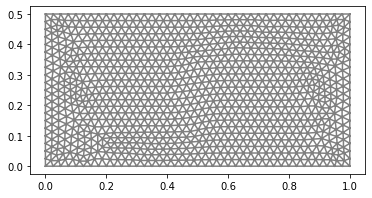

In [4]:
# Check .msh file
meshio_utils.print_diagnostic_gmsh(gmshfile)
# Convert to XDMF file
xdmfiles = meshio_utils.convert_gmsh_to_XDMF(gmshfile,prune_z=True) # prune_z prunes the third coordinate
# Load in Dolfin format (FEniCS)
dmesh = fenics_utils.DolfinMesh.init_from_xdmf(xdmfiles['tetra'*(dim==3)+'triangle'*(dim==2)],
                                               xdmfiles['triangle'*(dim==3)+'line'*(dim==2)])
fe.plot(dmesh.mesh)

# Get the physical tags from .geo file
meshtag = meshio_utils.read_phys_gmsh(xdmfiles['gmsh_physical_entities'])
# Boundaries
bnd_name = "Gamma" # From .geo file, may be a list
Gamma = meshtag[dim-2][bnd_name][0]
# Restriction of the mesh at the boundaries, useful for the space definition
Gamma_restriction = multiphenics_utils.build_MeshRestriction_from_tags(dmesh.mesh,
                                                                       dmesh.boundaries,[Gamma])


## 5: Finite dimensional spaces

In [5]:
# FE for \alpha_q and e_q
type_q = "RT"
order_q = 2
# FE for \alpha_p and e_p
type_p = "CG"
order_p = 3
# FE for u and y
type_b = "CG"
order_b = 3

# Care must be taken: for Galerkin FE, VectorFunctionSpace must be used instead of FunctionSpace
if ((type_q == 'CG') or (type_q == 'DG')):
    V_q = fe.VectorFunctionSpace(dmesh.mesh, type_q, order_q)
else:
    V_q = fe.FunctionSpace(dmesh.mesh, type_q, order_q)
V_p = fe.FunctionSpace(dmesh.mesh, type_p, order_p)
V_u = fe.FunctionSpace(dmesh.mesh, type_b, order_b)
V_y = fe.FunctionSpace(dmesh.mesh, type_b, order_b)

# Block function space (Mixed Finite Elements)
W = mpfe.BlockFunctionSpace([V_q, V_p, V_u, V_y], 
                            restrict=[None, None, Gamma_restriction, Gamma_restriction])

# Test/Trial functions
fun_test = mpfe.block_split(mpfe.BlockTestFunction(W))
fun_trial = mpfe.block_split(mpfe.BlockTrialFunction(W))
                                

## 6: Dirac structure and Jacobian

In [6]:
# Young modulus and its inverse (for the sake of simplicity)
Txx = "2."
Tyy = "1."
Txy = "0.2 * (1+x[0]) * (1-x[0])"
T = fe.Expression([[Txx,Txy],
                   [Txy,Tyy]], degree=2)
Tinv = fe.Expression([[Tyy,"-"+Txy],
                      ["-"+Txy,Txx]], degree=2)/fe.det(T)

# Mass density
rho = fe.Expression("2. + 0.25 * (1+x[0]) * (1-x[0])", degree=2)

def Dirac(fun_trial,fun_test,dx,ds):
    
    # Split trial/test functions
    (e_q, e_p, u_b, y_b) = fun_trial
    (v_q, v_p, v_u, v_y) = fun_test
    
    # Mass matrices
    M_q = fe.dot(e_q,fe.dot(Tinv,v_q))*dx
    M_p = e_p*rho*v_p*dx
    M_u = u_b*v_u*ds
    M_y = y_b*v_y*ds
    
    # Matrices constituting J
    D = fe.dot(fe.grad(e_p), v_q)*dx
    Dt = fe.dot(e_q, fe.grad(v_p))*dx
    B = u_b*v_p*ds
    Bt = e_p*v_y*ds
    
    # It is not necessary to add null variational formulations, multiphenics handles this
    # Matrices M and J are rewritten with E and A as : E dz/dt = A z
    E = [
            # - M_q d(e_q)/dt
            [ -M_q ],
            # - M_p d(e_p)/dt
            [ -M_p ]
        ]
    
    A = [
            # D e_p
            [ D ],
            # -D^T e_q + B u_b
            [ -Dt, B ],
            # M_y y = -B^T e_p
            [ -M_y, -Bt ],
        
            # The following will allow to treat time-varying control "outside" the Dirac method
            # using a method defining only u_b thanks to v_b: see Define_Control method
            [ -M_u ]
        ]
    
    return (E, A)

# Jacobian consists of E and A when considering the general DAE form: F(t,z,dz/dt) = 0
Jacobian = lambda : Dirac(fun_trial,fun_test,dmesh.dx,dmesh.ds)


## 7: Boundary source term

In [7]:
# UFL Format
t_control_begin = 0.5
t_control_end = 2.5
control = "5. * x[0] * x[0] * x[1] * sin(t-"+str(t_control_begin)+") * (t >"+str(t_control_begin) \
            +") * sin("+str(t_control_end)+"-t) * (t < "+str(t_control_end)+")"
u = fe.Expression(control, element=V_u.ufl_element(), domain=dmesh.mesh, t=0.)

def Define_Control(t,u,fun_test,ds):
    
    u.t = t # u at time t
    
    (v_q, v_p, v_u, v_y) = fun_test # Split test functions
    
    return [ [ u*v_u*ds ] ] # with the last line of the Dirac method, this defines u_b with u

# Residual consists of the time-varying forcing when considering the general DAE form: F(t,z,dz/dt) = 0
Residual = lambda t : Define_Control(t,u,fun_test,dmesh.ds)


# 8: Initial data

In [8]:
x0Array = np.zeros(W.dim(),) # Initialisation q0 and p0

q0 = fe.Expression(["0.","0."], element=V_q.ufl_element(), domain=dmesh.mesh)
q0Fun = fe.interpolate(q0, V_q) # Warning: compatible condition "initial data -- boundary control" must be fulfilled
x0Array[0:V_q.dim()] = np.array(q0Fun.vector())

p0 = fe.Expression("0.", element=V_p.ufl_element(), domain=dmesh.mesh)
p0Fun = fe.interpolate(p0, V_p)
x0Array[V_q.dim():V_q.dim()+V_p.dim()] = np.array(p0Fun.vector())

x0 = PETSc.Vec().createWithArray(x0Array)


# 9: Time resolution

In [9]:
# PETSc TS solver options (time integration)
# OptDB collects options for PETSc TS: https://petsc.org/release/docs/manualpages/TS/index.html
# a statement as -option can be passed to PETSc TS by setting OptDB["option"]
OptDB = PETSc_utils.get_cleared_options_db()
PETSc.Sys.pushErrorHandler("python") # To see correctly the errors: interferences between FEniCS and PETSc???

OptDB["ts_type"] = "cn" # Crank-Nicolson
OptDB["ksp_type"] = "preonly" # Direct linear solver
OptDB["pc_type"] = "lu" # LU preconditioner

dt = 0.01
tf = 5.
Integration_params = {'dt_export':5.*dt}

# u_b and y_b are algebraic
idx_Lagrange_multipliers = np.concatenate((W.block_dofmap().block_owned_dofs__global_numbering(2),
                                           W.block_dofmap().block_owned_dofs__global_numbering(3)))

name = "2D Wave equation -- Neumann boundary control"
dae = multiphenics_utils.PDAE_linear(Residual,Jacobian,
                                     W.dim(),name,idx_alg=idx_Lagrange_multipliers)

PETSc_utils.TS_integration_dae(dae,x0,dt,tf,**Integration_params)

t_sol = dae.history['t']
z_sol = dae.history['z']


i=       0 t=       0 * (0s)
i=       1 t=    0.01   (0s)
i=       2 t=    0.02   (0s)
i=       3 t=    0.03   (0s)
i=       4 t=    0.04   (0s)
i=       5 t=    0.05 * (0s)
i=       6 t=    0.06   (0s)
i=       7 t=    0.07   (0s)
i=       8 t=    0.08   (0s)
i=       9 t=    0.09   (0s)
i=      10 t=     0.1 * (0s)
i=      11 t=    0.11   (0s)
i=      12 t=    0.12   (0s)
i=      13 t=    0.13   (0s)
i=      14 t=    0.14   (0s)
i=      15 t=    0.15 * (0s)
i=      16 t=    0.16   (0s)
i=      17 t=    0.17   (0s)
i=      18 t=    0.18   (0s)
i=      19 t=    0.19   (0s)
i=      20 t=     0.2 * (0s)
i=      21 t=    0.21   (0s)
i=      22 t=    0.22   (0s)
i=      23 t=    0.23   (0s)
i=      24 t=    0.24   (0s)
i=      25 t=    0.25 * (0s)
i=      26 t=    0.26   (0s)
i=      27 t=    0.27   (0s)
i=      28 t=    0.28   (0s)
i=      29 t=    0.29   (1s)
i=      30 t=     0.3 * (1s)
i=      31 t=    0.31   (1s)
i=      32 t=    0.32   (1s)
i=      33 t=    0.33   (1s)
i=      34 t= 

i=     276 t=    2.76   (79s)
i=     277 t=    2.77   (79s)
i=     278 t=    2.78   (80s)
i=     279 t=    2.79   (80s)
i=     280 t=     2.8 * (80s)
i=     281 t=    2.81   (81s)
i=     282 t=    2.82   (81s)
i=     283 t=    2.83   (81s)
i=     284 t=    2.84   (82s)
i=     285 t=    2.85 * (82s)
i=     286 t=    2.86   (82s)
i=     287 t=    2.87   (83s)
i=     288 t=    2.88   (83s)
i=     289 t=    2.89   (83s)
i=     290 t=     2.9 * (84s)
i=     291 t=    2.91   (84s)
i=     292 t=    2.92   (84s)
i=     293 t=    2.93   (85s)
i=     294 t=    2.94   (85s)
i=     295 t=    2.95 * (85s)
i=     296 t=    2.96   (86s)
i=     297 t=    2.97   (86s)
i=     298 t=    2.98   (86s)
i=     299 t=    2.99   (86s)
i=     300 t=       3 * (87s)
i=     301 t=    3.01   (87s)
i=     302 t=    3.02   (88s)
i=     303 t=    3.03   (88s)
i=     304 t=    3.04   (88s)
i=     305 t=    3.05 * (89s)
i=     306 t=    3.06   (89s)
i=     307 t=    3.07   (89s)
i=     308 t=    3.08   (90s)
i=     309

# 10: Post-processing

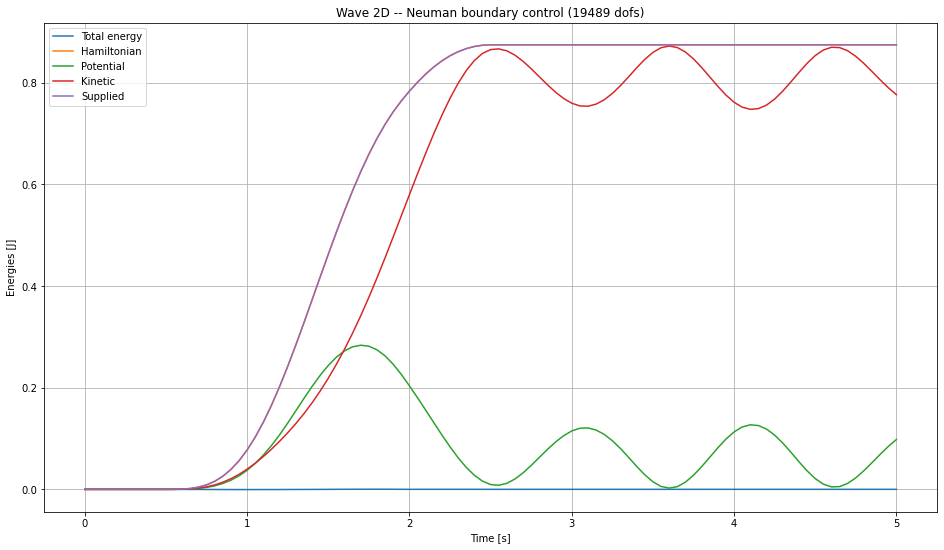

In [10]:
def Plot_Hamiltonian(t,z,u,Tinv,rho,fun_trial,fun_test,dx,ds):
    
    # Number of time steps
    Nt = np.array(t).size
    
    # For the potential energy
    Hamq = np.zeros((Nt,))
    
    # For the kinetic energy
    Hamp = np.zeros((Nt,))
    
    # For the total mechanical energy (the Hamiltonian)
    Ham = np.zeros((Nt,))
    
    # For supplied energy
    Supplied = np.zeros((Nt,))
    
    for k in range(1,Nt):
        # Extract solutions
        e_q = mpfe.BlockFunction(W,mpfe.la.BlockPETScVector(z[k]))[0]
        e_p_old = mpfe.BlockFunction(W,mpfe.la.BlockPETScVector(z[k-1]))[1]
        e_p = mpfe.BlockFunction(W,mpfe.la.BlockPETScVector(z[k]))[1]
        # Compute energies
        Hamq[k] = 0.5*fe.assemble(fe.dot(e_q,fe.dot(Tinv, e_q))*dx)
        Hamp[k] = 0.5*fe.assemble(e_p*rho*e_p*dx)
        Ham[k] = Hamq[k] + Hamp[k]
        u.t = t[k-1]
        Supplied[k] = Supplied[k-1] + 0.5 * (t[k] - t[k-1]) * fe.assemble(e_p_old*u*ds)
        u.t = t[k]
        Supplied[k] = Supplied[k] + 0.5 * (t[k] - t[k-1]) * fe.assemble(e_p*u*ds)
    
    fig = plt.figure(figsize=(16,9))
    plt.plot(t,Ham-Supplied,t,Ham,t,Hamq,t,Hamp,t,Supplied)
    plt.title("Wave 2D -- Neuman boundary control ("
              +str(W.tabulate_dof_coordinates().shape[0])+" dofs)")
    plt.xlabel("Time [s]")
    plt.ylabel("Energies [J]")
    plt.grid(axis="both")
    plt.legend(["Total energy","Hamiltonian","Potential","Kinetic","Supplied"])
    plt.show()

Plot_Hamiltonian(t_sol,z_sol,u,Tinv,rho,fun_trial,fun_test,dmesh.dx,dmesh.ds)


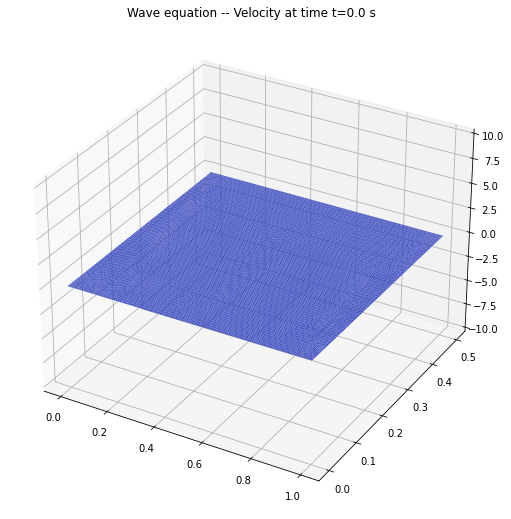

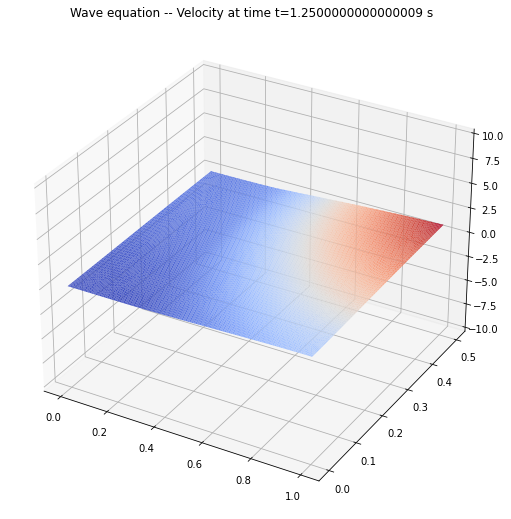

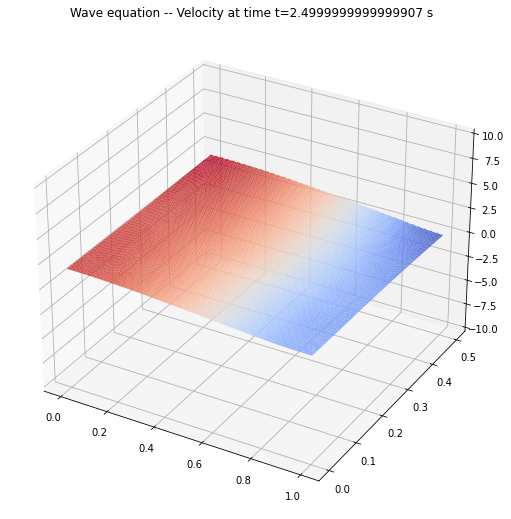

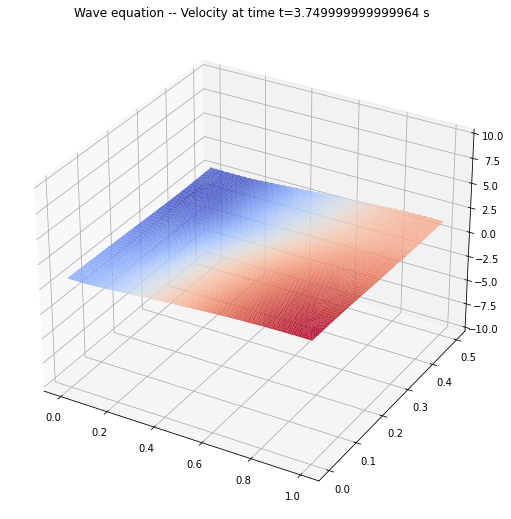

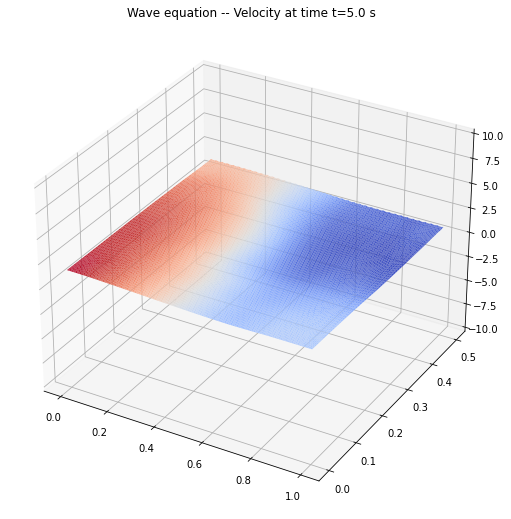

In [11]:
# Plot some instants (in % of final time)
instants = (0.,0.25,0.5,0.75,1.)

# Get coordinates
dofs = V_p.tabulate_dof_coordinates().reshape((-1, dmesh.mesh.geometry().dim()))
x = [dof[0] for dof in dofs]
y = [dof[1] for dof in dofs]

def Plot_Instant(t,z,W,V_p,instant):
    idx = min(int(instant*len(t)),len(t)-1)
    e_p = mpfe.BlockFunction(W,mpfe.la.BlockPETScVector(z[idx]))[1]
    
    fig = plt.figure(figsize=(16,9))
    ax = fig.add_subplot(1, 1, 1, projection='3d')
    plt.title("Wave equation -- Velocity at time t="+str(t[idx])+" s")
    ax.plot_trisurf(x,y,e_p.vector(), cmap=plt.cm.coolwarm)
    ax.set_zlim(-10, 10)
    plt.show()

for instant in instants:
    Plot_Instant(t_sol,z_sol,W,V_p,instant)


In [12]:
# Export for ParaView
pvdfile = 'vtk/'
sol_idx=[0,1]; sol_name = ["e_q","e_p"]
print(f"Export for paraview...")
multiphenics_utils.export_pvd(pvdfile,sol_idx,sol_name,t_sol,z_sol,W)
print("Done.")


Export for paraview...
Export to <dolfin.cpp.io.File object at 0x7f4e116f3630>...
Step t=0.0
Step t=0.05
Step t=0.09999999999999999
Step t=0.15
Step t=0.20000000000000004
Step t=0.25000000000000006
Step t=0.3000000000000001
Step t=0.35000000000000014
Step t=0.4000000000000002
Step t=0.45000000000000023
Step t=0.5000000000000002
Step t=0.5500000000000003
Step t=0.6000000000000003
Step t=0.6500000000000004
Step t=0.7000000000000004
Step t=0.7500000000000004
Step t=0.8000000000000005
Step t=0.8500000000000005
Step t=0.9000000000000006
Step t=0.9500000000000006
Step t=1.0000000000000007
Step t=1.0500000000000007
Step t=1.1000000000000008
Step t=1.1500000000000008
Step t=1.2000000000000008
Step t=1.2500000000000009
Step t=1.300000000000001
Step t=1.350000000000001
Step t=1.400000000000001
Step t=1.450000000000001
Step t=1.500000000000001
Step t=1.5500000000000012
Step t=1.6000000000000012
Step t=1.6500000000000012
Step t=1.7000000000000013
Step t=1.7500000000000013
Step t=1.8000000000000014